### 1) Imports

In [1]:
import numpy as np
import pandas as pd

from timecopilot import TimeCopilotForecaster
from timecopilot.models.foundation.chronos import Chronos
from timecopilot.models.stats import SeasonalNaive


 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.


### 2) Load dataset (baseline format)
TimeCopilot expects a DataFrame with at least:
- `unique_id` (series id)
- `ds` (timestamp)
- `y` (target)

This is the **standard Chronos usage** (no exogenous variables yet).


In [2]:
df = pd.read_csv(
    "https://timecopilot.s3.amazonaws.com/public/data/events_pageviews.csv",
    parse_dates=["ds"],
)

df.head()


,unique_id,ds,y
0,Oktoberfest,2020-01-31,25376
1,Oktoberfest,2020-02-29,28470
2,Oktoberfest,2020-03-31,23816
3,Oktoberfest,2020-04-30,46186
4,Oktoberfest,2020-05-31,31213


### 3) Plot the raw time series
Sanity check: visualize the historical `y` values for each `unique_id`.


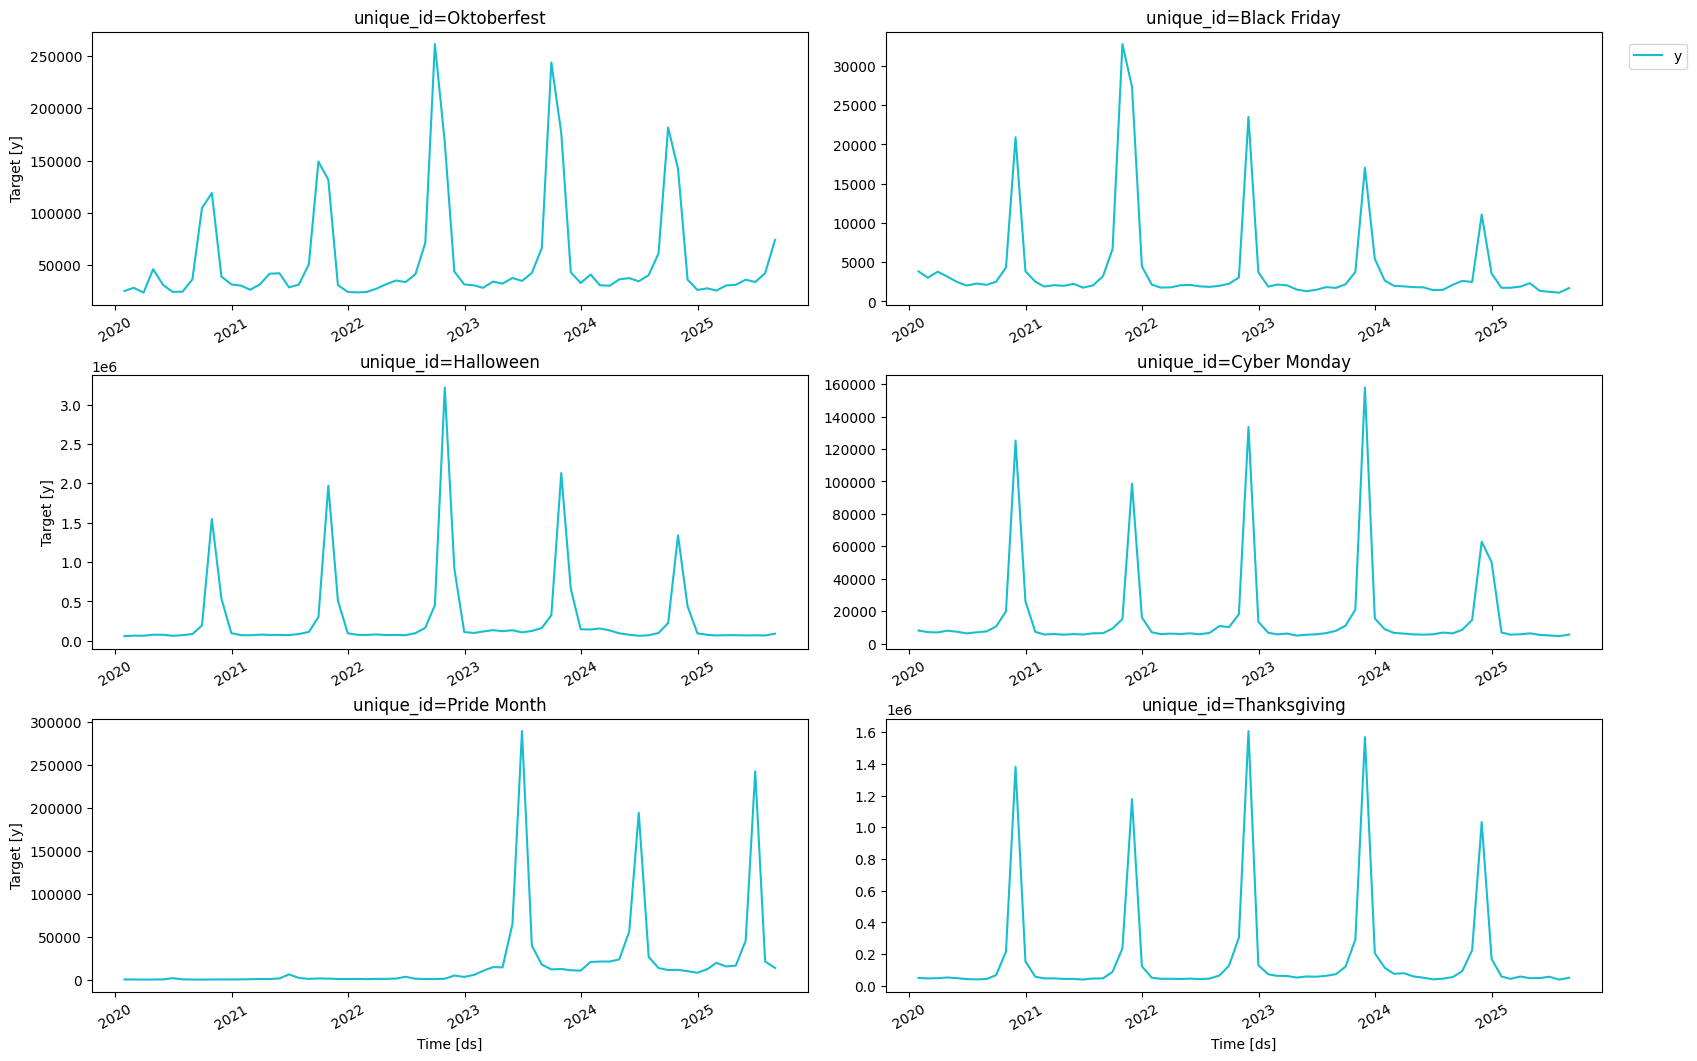

In [3]:
TimeCopilotForecaster.plot(df)


### 4) Add candidate exogenous columns (still NOT used by the model yet)
Here we create extra columns like `month` and `is_holiday_season`.

Important:
- Adding these columns to the DataFrame **does not automatically enable exogenous forecasting**.
- Exogenous variables are used **only when user explicitly pass `exog_cols=[...]` to the model**.

This step only prepares the data.


In [ ]:
df_exog = df.copy()
df_exog["month"] = df_exog["ds"].dt.month.astype(np.int16)
df_exog["is_holiday_season"] = df_exog["ds"].dt.month.isin([11, 12]).astype(np.int8)

# Noise feature: fixed seed for reproducibility
rng = np.random.default_rng(0)
df_exog["noise_feature"] = rng.standard_normal(len(df_exog)).astype(np.float32)

df_exog.head()


### 5) Backwards-compatibility check (extra columns should NOT break anything)
We run cross-validation using models that **do not support exogenous variables** (e.g., Chronos T5 variants).

Because exog is now **opt-in**, these models will simply ignore extra DataFrame columns and still run normally.


In [ ]:
models = [
    Chronos(repo_id="amazon/chronos-t5-small", alias="t5-small"),  # doesn't support exog
    SeasonalNaive(alias="SeasonalNaive"),
]
tcf = TimeCopilotForecaster(models=models)

cv_df = tcf.cross_validation(df=df_exog, h=12, level=[80])
cv_df.head()


### 6) Define Chronos-2 models (exogenous OFF vs ON)

Here we create two Chronos-2 models using the same data:

- `chronos2_no_exog`: standard Chronos behavior (uses only `unique_id`, `ds`, `y`)
- `chronos2_with_exog`: exogenous enabled via  
  `exog_cols=["month", "is_holiday_season"]`

This is the **only place** where exogenous variables are defined.  
If `exog_cols` is not set, extra DataFrame columns are ignored.


In [7]:
chronos2_no_exog = Chronos(
    repo_id="amazon/chronos-2",
    alias="chronos2_no_exog",
    exog_cols=None,  # explicit: no exog
)

chronos2_with_exog = Chronos(
    repo_id="amazon/chronos-2",
    alias="chronos2_with_exog",
    exog_cols=["month", "is_holiday_season"],  # explicit: exog requested
)

tcf = TimeCopilotForecaster(models=[chronos2_no_exog, chronos2_with_exog])


### 7) Run cross-validation
Run the same CV setup for both models on identical data.
This produces forecasts with and without exogenous variables.


In [8]:
level = [80]
cv_df = tcf.cross_validation(df=df_exog, h=12, level=level)
cv_df.head()


1it [00:05,  5.70s/it]
1it [00:07,  7.43s/it]


,unique_id,ds,cutoff,y,chronos2_no_exog,chronos2_no_exog-lo-80,chronos2_no_exog-hi-80,chronos2_with_exog,chronos2_with_exog-lo-80,chronos2_with_exog-hi-80
0,Black Friday,2024-09-30,2024-08-31,2607,2096.0,1664.0,3264.0,2064.0,1568.0,3376.0
1,Black Friday,2024-10-31,2024-08-31,2470,2688.0,1648.0,8384.0,4160.0,1936.0,10112.0
2,Black Friday,2024-11-30,2024-08-31,11058,18432.0,6208.0,30464.0,19840.0,9856.0,29568.0
3,Black Friday,2024-12-31,2024-08-31,3548,3264.0,1632.0,9536.0,4016.0,1896.0,8896.0
4,Black Friday,2025-01-31,2024-08-31,1724,1992.0,1568.0,3056.0,1992.0,1496.0,2896.0


### 8) Check that exogenous variables affect the forecast
We compare the two forecast outputs.
If the difference is non-zero, exogenous inputs are being used.


In [ ]:
diff = (cv_df["chronos2_no_exog"] - cv_df["chronos2_with_exog"]).abs()
print("mean abs diff:", float(diff.mean()))
print("max abs diff:", float(diff.max()))

assert diff.max() > 0, "Forecasts are identical, exog path might not be used."


mean abs diff: 6902.0
max abs diff: 90112.0


### 9) Plot forecasts


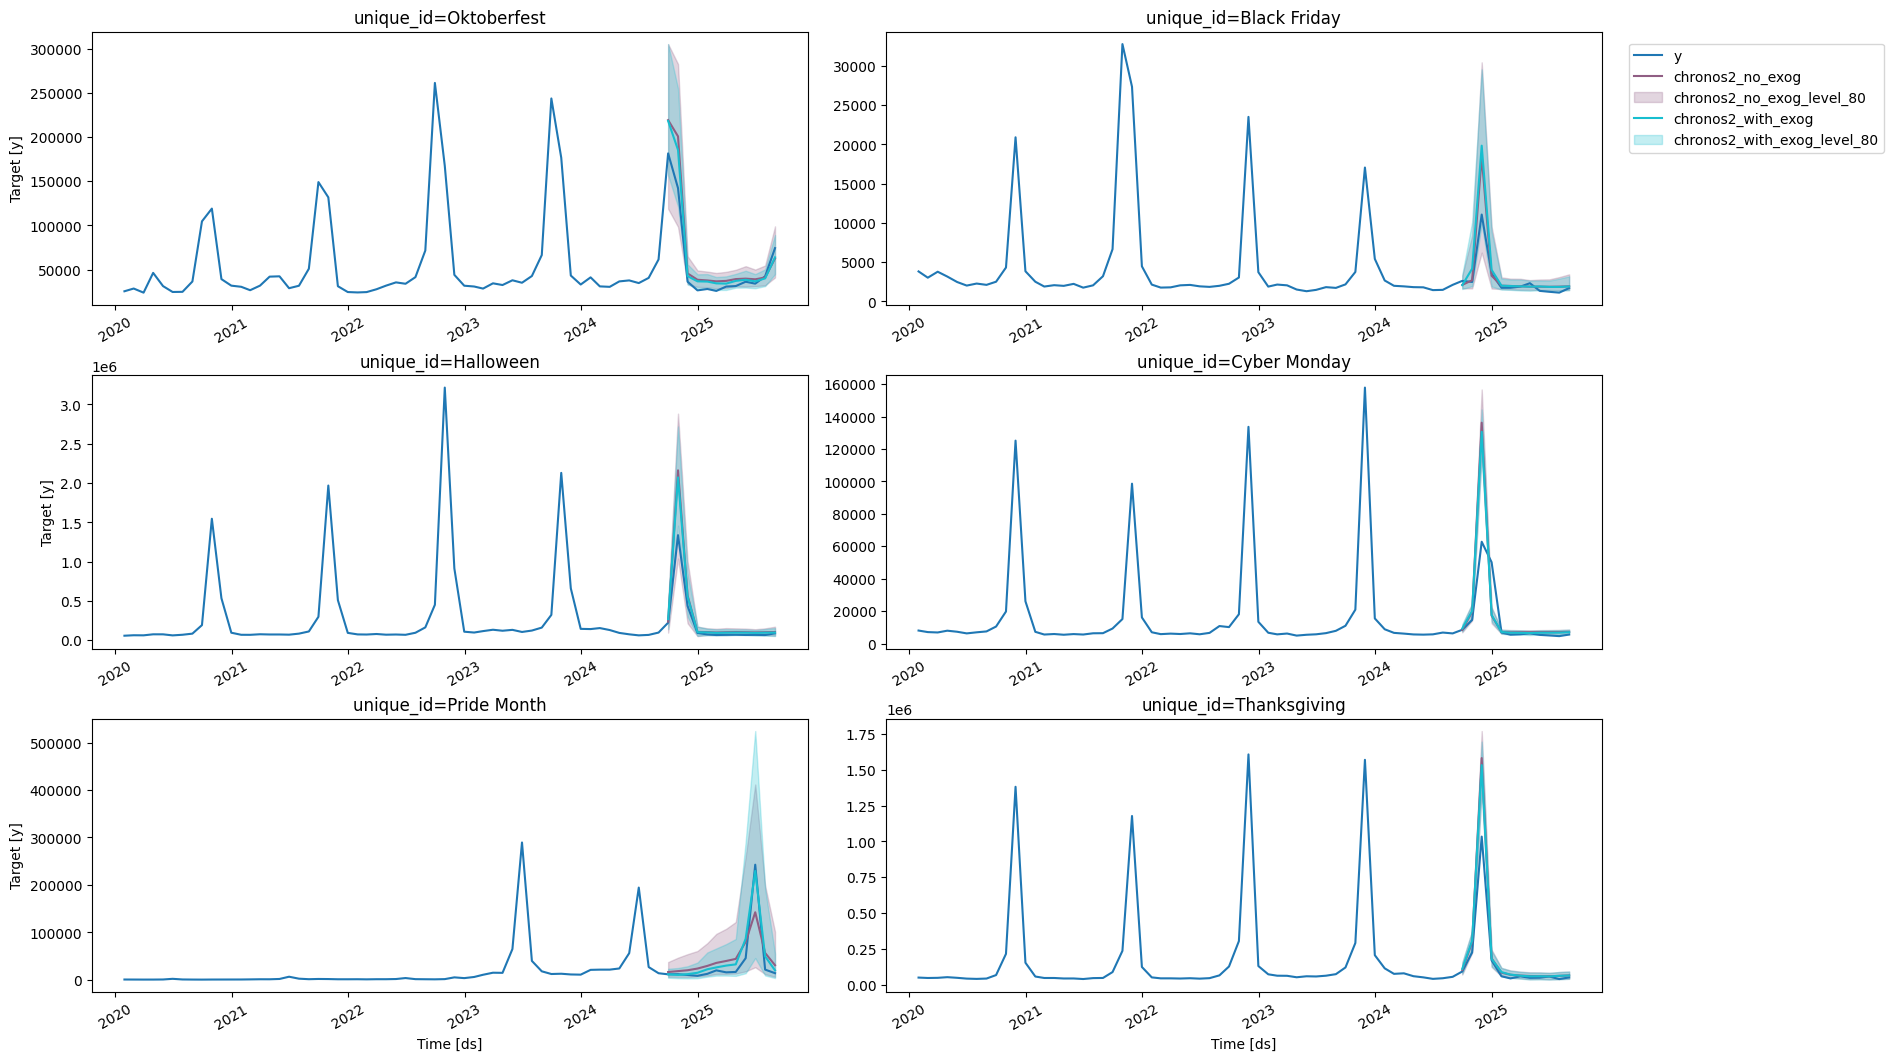

In [12]:
tcf.plot(df_exog, cv_df.drop(columns=["cutoff", "y"]), level=[80])
